In [1]:
import pathlib
import re
import functools


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pybtex.database


import dateutil.parser


%matplotlib inline

In [2]:
path = pathlib.Path('~/src/sealevel/data/parliament/kamerstukken_tot_1995.json').expanduser()

In [3]:
year_re = re.compile(r'\b\d{4}\b')
df = pd.read_json(path)
year = df.document.apply(lambda x: year_re.search(x)[0])
df['year'] = year
df['extract'] = df['extract'].apply(lambda x: x.lower())
df['year'] = df.year.astype('int')

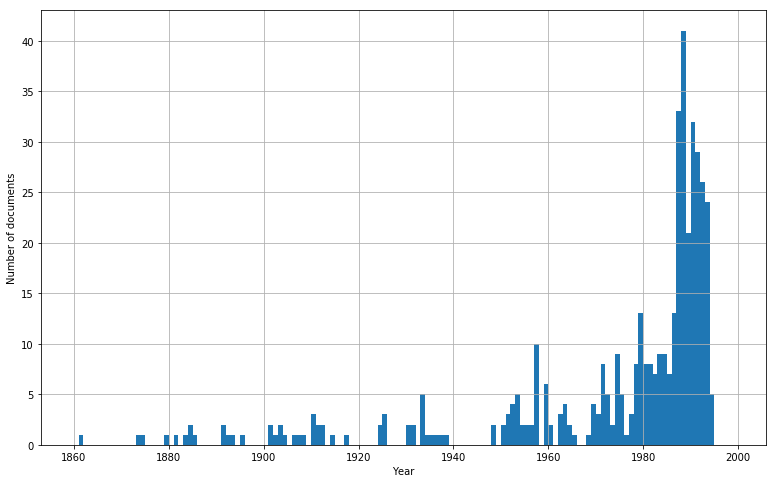

In [4]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.hist(df.year, bins=np.arange(1860, 2000, 1))
ax.set_ylabel('Number of documents')
ax.set_xlabel('Year')
ax.grid(True)


In [5]:
df['stijging_term'] = df['extract'].apply(lambda x:'stijging' in x or 'rijzing' in x)
df['daling_term'] = df['extract'].apply(lambda x:'daling' in x)
df['co2_term'] = df['extract'].apply(lambda x:'dioxide' in x or 'co2' in x)
df['klimaat_term'] = df['extract'].apply(lambda x:'klimaat' in x)
df['ijs_term'] = df['extract'].apply(lambda x:'ijs' in x or 'pool' in x or 'smelt' in x or 'groenland' in x or 'polen' in x or 'antarctica' in x)
df['gas_term'] = df['extract'].apply(lambda x:'gas' in x or 'boring' in x)
df['zee_term'] = df['extract'].apply(lambda x: 'zee' in x)
df['bodem_term'] = df['extract'].apply(lambda x: 'bodem' in x)
df['meter_term'] = df['extract'].apply(lambda x: 'meter' in x)

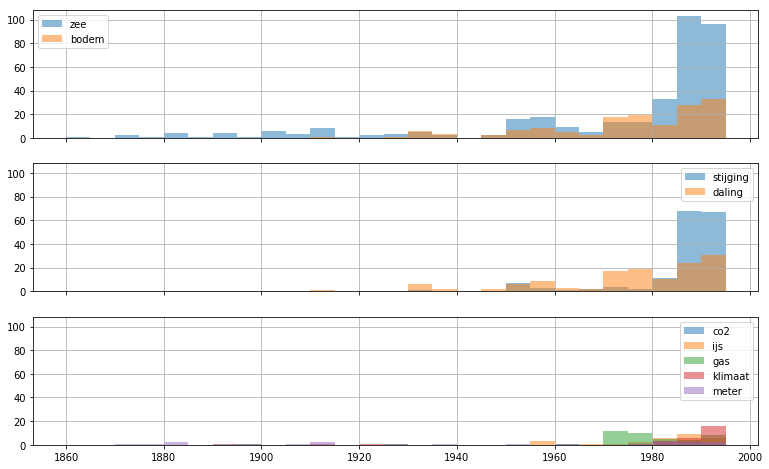

In [6]:
bins = np.arange(1860, 2000, 5)

fig, axes = plt.subplots(3, 1, figsize=(13, 8), sharex=True, sharey=True)
df[df['zee_term']].year.hist(bins=bins, ax=axes[0], alpha=0.5, label='zee')
df[df['bodem_term']].year.hist(bins=bins, ax=axes[0], alpha=0.5, label='bodem')
df[df['stijging_term']].year.hist(bins=bins, ax=axes[1], alpha=0.5, label='stijging')
df[df['daling_term']].year.hist(bins=bins, ax=axes[1], alpha=0.5, label='daling')
df[df['co2_term']].year.hist(bins=bins, ax=axes[2], alpha=0.5, label='co2')
df[df['ijs_term']].year.hist(bins=bins, ax=axes[2], alpha=0.5, label='ijs')
df[df['gas_term']].year.hist(bins=bins, ax=axes[2], alpha=0.5, label='gas')
df[df['klimaat_term']].year.hist(bins=bins, ax=axes[2], alpha=0.5, label='klimaat')
df[df['meter_term']].year.hist(bins=bins, ax=axes[2], alpha=0.5, label='meter')

axes[0].legend(loc='best')
axes[1].legend(loc='best')
axes[2].legend(loc='best')

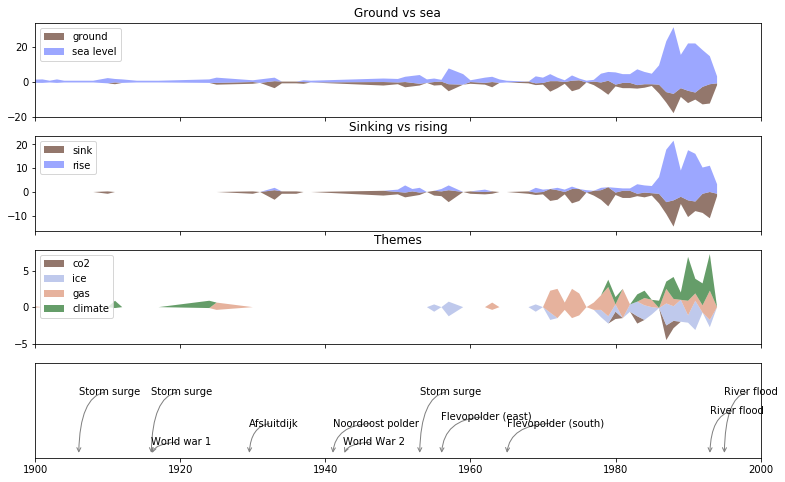

In [15]:
summed = df.groupby('year').agg('sum')

stacks = [
    {
        "title": "Ground vs sea",
        "labels": ["ground", "sea level"],
        "columns": ["bodem_term", "zee_term"],
        "colors": ['#785547', '#8491FF']
    },
    {
        "title": "Sinking vs rising",
        "labels": ["sink", "rise"],
        "columns": ["daling_term", "stijging_term"],
        "colors": ['#785547', '#8491FF']
    },
    {
        "title": "Themes",
        "labels": ["co2", "ice", "gas", "climate"],
        "columns": ['co2_term', "ijs_term", "gas_term", "klimaat_term"],
        "colors": ['#785547', '#AFBCE8', '#E09F85', '#3F8543']
    }
]




# columns = ['daling', 'stijging']
fig, axes = plt.subplots(len(stacks) + 1, 1, figsize=(13, 8), sharex=True)
for stack, ax in zip(stacks, axes):
    ax.set_title(stack['title'])
    ax.stackplot(
        summed.index, 
        summed[stack['columns']].values.T, 
        baseline='wiggle', 
        labels=stack['labels'],
        colors=stack['colors'],
        alpha=0.8
    )
    ax.legend(loc='upper left')
    ax.set_xlim(1900, 2000)

annotations = [
    {
        "year": [1953],
        "text": "Storm surge",
        "y": 1
    },
    {
        "year": [1927, 1932],
        "text": "Afsluitdijk",
        "y": 0.5
    },
    {
        "year": [1940, 1942],
        "text": "Noordoost polder",
        "y": 0.5
    },
    {
        "year": [1916],
        "text": "Storm surge",
        "y": 1
    },
    {
        "year": [1955, 1957],
        "text": "Flevopolder (east)",
        "y": 0.6
    },
    {
        "year": [1962, 1968],
        "text": "Flevopolder (south)",
        "y": 0.5
    },
    {
        "year": [1906],
        "text": "Storm surge",
        "y": 1
    },
    {
        "year": [1995],
        "text": "River flood",
        "y": 1
    },    
    {
        "year": [1993],
        "text": "River flood",
        "y": 0.7
    },    
    {
        "year": [1940, 1945],
        "text": "World War 2",
        "y": 0.2
    },
    {
        "year": [1914, 1918],
        "text": "World war 1",
        "y": 0.2
    }
]
ax = axes[-1]
ax.yaxis.set_ticks([])
ax.set_ylim(0, 1.5)
for annotation in annotations:

    style = 'angle3,angleA=0,angleB=90'
    x = [np.mean(annotation['year'])]
    y = [0, annotation['y']] 
    ax.annotate(
        annotation['text'],
        xy=(x[0], y[0]), 
        xycoords='data',
        xytext=(x[-1], y[-1]), 
        textcoords='data',
        arrowprops=dict(
            arrowstyle="->", 
            color="0.5",
            shrinkA=5, 
            shrinkB=5,
            patchA=None,
            patchB=None,
            connectionstyle=style
        )
    )



fig.savefig('parliament.pdf')

In [16]:

def extract_re(expression):
    def extracter(text):
        compiled = re.compile(expression, re.IGNORECASE | re.MULTILINE)
        match = compiled.search(text)
        if match:
            return match.groupdict()
        else:
            return {}
    return extracter
        
    
    
df['period'] = df['document'].apply(
    extract_re(r'\b(?P<start>\d{4})\-(?P<end>\d{4})\b')
)
df['kamerstuk'] = df['document'].apply(
    extract_re(r'\bkamerstuknummer\s+(?P<kamerstuk>((\d+|[IVXMD\s]+)))\b')
)
df['ondernummer'] = df['document'].apply(
    extract_re(r'\bondernummer\s+(?P<ondernummer>((\d+|[IVXMD\s]+)))\b')
)
df['nummer'] = df['document'].apply(
    extract_re(r'\bnummer\s+(?P<nummer>((\d+|[IVXMD\s]+)))\b')
)
df['date'] = df['document'].apply(
    extract_re(r'\b(?P<date>\d{1,2}\s+(?P<month>\w+)\s+\d{4})\b')
)
df['type'] = df['document'].apply(
    extract_re(r'^(?P<type>\w+)\b')
)
df[df['type'].apply(lambda x: not x)]

def merge_dicts(row):
    record = row.values.tolist()
    return functools.reduce(lambda x, y: dict(**x, **y), record, {})
df['meta'] = df[['period', 'type', 'date', 'kamerstuk', 'ondernummer', 'nummer']].apply(merge_dicts, axis=1)
df['meta'].iloc[10]


def month2number(month):
    months = {
        'januari': 1, 
        'februari': 2,
        'maart': 3,
        'april': 4,
        'mei': 5,
        'juni': 6,
        'juli': 7,
        'augustus': 8,
        'september': 9,
        'oktober': 10,
        'october': 10,
        'november': 11,
        'december': 12,
        '': ''
    }
    return str(months[month])
df['month'] = df.date.apply(
    lambda x: month2number(x.get('month', '').lower())
)


In [17]:
class DutchParserInfo(dateutil.parser.parserinfo):
    
    WEEKDAYS = [
        ("Mo", "Maandag"),
        ("Di", "Dinsdag"),
        ("Wo", "Woensdag"),
        ("Do", "Donderdag"),
        ("Vr", "Vrijdag"),
        ("Za", "Zaterdag"),
        ("Zo", "Zondag")
    ]
    dayfirst = True
    MONTHS = [
        ('Jan', 'Januari'),
        ('Feb', 'Februari'),
        ('Mar', 'Maart'),
        ('Apr', 'April'),
        ('May', 'Mei'),
        ('Jun', 'Juni'),
        ('Jul', 'Juli'),
        ('Aug', 'Augustus'),
        ('Sep', 'September'),
        ('Oct', 'Oktober'),
        ('Nov', 'November'),
        ('Dec', 'December')
    ]

DutchParserInfo.MONTHS

date = df['meta'].apply(lambda x:x.get('date')).iloc[5]

def meta2date(meta):
    if not meta:
        return
    if not 'date' in meta:
        return
    date_str = meta.get('date') 
    try:
        date = dateutil.parser.parse(date_str, parserinfo=DutchParserInfo())
    except ValueError:
        date = dateutil.parser.parse(date_str)
    return date
df['date'] = df['meta'].apply(meta2date)

In [10]:

person = pybtex.database.Person('Uknown Author')

    
def row2entry(row):
    fields = dict(
        author=str(person),
        title=row.title or row.heading.strip(),
        url=row.pdf,
        year=str(row.year)
    )
    if row.month:
        fields['month'] = row.month
    if row.meta.get('kamerstuk'):
        if row.meta.get('ondernummer'):
            fields['number'] = row.meta.get('kamerstuk') + ' ' + row.meta.get('ondernummer')
        else:
            fields['number'] = row.meta.get('kamerstuk')
    elif row.meta.get('nummer'):
        if row.meta.get('ondernummer'):
            fields['number'] = row.meta.get('nummer') + ' ' + row.meta.get('ondernummer')
        else:
            fields['number'] = row.meta.get('nummer')
    if row.meta.get('type'):
        fields['type'] = row.meta.get('type')
        
    
    
    return pybtex.database.Entry('misc', list(fields.items()))


def row2key(row):
    entry = row.entry
    author = pybtex.database.Person(entry.fields.get('author'))
    last_name = author.last_names[0]
    return "%s%d_%d" % (last_name, row.year, row.name)
    

df['entry'] = df.apply(row2entry, axis=1)
df['citekey'] = df.apply(row2key, axis=1)

In [11]:
bibliography = pybtex.database.BibliographyData({
    row.citekey : row.entry
    for i, row 
    in df.iterrows()
})

In [12]:
with open('parliament-bibliography.bib', 'w') as f:
    f.write(bibliography.to_string('bibtex'))

In [13]:
# fix url encoding (replace \% with %)
! sed -i '' s'#\\\%#\%#'g parliament-bibliography.bib